In [23]:
import numpy as np
import pandas as pd
import datetime as dt

online = pd.read_csv('Online Retail.csv', sep=';')

# convert object to datetime
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

# convert object to float
online['UnitPrice'] = online['UnitPrice'].apply(lambda x: x.replace(',', '.'))
online['UnitPrice'] = online['UnitPrice'].apply(lambda col:pd.to_numeric(col, errors='coerce'))

In [24]:
online.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [25]:
def get_month(x): return dt.datetime(x.year, x.month, 1)

online['InvoiceMonth'] = online['InvoiceDate'].apply(get_month)

grouping = online.groupby('CustomerID')['InvoiceMonth']

online['CohortMonth'] = grouping.transform('min')


In [26]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [27]:
invoice_year, invoice_month, _ = get_date_int(online, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(online, 'CohortMonth')

years_diff = invoice_year - cohort_year

months_diff = invoice_month - cohort_month

online['CohortIndex'] = years_diff * 12 + months_diff + 1


In [28]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,2010-01-01,2010-01-01,1.0
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01,2010-01-01,1.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,2010-01-01,2010-01-01,1.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01,2010-01-01,1.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,2010-01-01,2010-01-01,1.0


In [37]:
# Count monthly active customers from each cohort
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

print(cohort_counts)

CohortIndex   1.0    2.0    3.0    4.0    5.0    6.0    7.0    8.0    9.0   \
CohortMonth                                                                  
2010-01-01    98.0    9.0    4.0    NaN    7.0    7.0    4.0   10.0   10.0   
2010-02-01   108.0    2.0    NaN    NaN    3.0    7.0    5.0   12.0    5.0   
2010-03-01    49.0    NaN    1.0    1.0    1.0    2.0    5.0    NaN    NaN   
2010-05-01    68.0    3.0    3.0    2.0    3.0    1.0    NaN   24.0   32.0   
2010-06-01    76.0    2.0    4.0    4.0    1.0    NaN   26.0   29.0   25.0   
2010-07-01    53.0    2.0    2.0    1.0    NaN    9.0   24.0   22.0   22.0   
2010-08-01    87.0    3.0    2.0    NaN   30.0   37.0   30.0   34.0   33.0   
2010-09-01    83.0    1.0    NaN   23.0   29.0   20.0   30.0   23.0   29.0   
2010-10-01    38.0    NaN   11.0   15.0   12.0   15.0   18.0    8.0   14.0   
2010-12-01   288.0  102.0   79.0   97.0   93.0  105.0  108.0   96.0   93.0   
2011-01-01   599.0  142.0  154.0  145.0  169.0  186.0  182.0  14

In [38]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [39]:
retention

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01-01,1.0,0.091837,0.040816,NaN,0.071429,0.071429,0.040816,0.102041,0.102041,0.051020,...,0.387755,0.408163,0.367347,0.448980,0.418367,0.377551,0.418367,0.448980,0.408163,0.234694
2010-02-01,1.0,0.018519,NaN,NaN,0.027778,0.064815,0.046296,0.111111,0.046296,NaN,...,0.361111,0.351852,0.398148,0.444444,0.314815,0.379630,0.416667,0.490741,0.175926,NaN
2010-03-01,1.0,NaN,0.020408,0.020408,0.020408,0.040816,0.102041,NaN,NaN,0.285714,...,0.469388,0.326531,0.387755,0.387755,0.265306,0.489796,0.469388,0.183673,NaN,NaN
2010-05-01,1.0,0.044118,0.044118,0.029412,0.044118,0.014706,NaN,0.352941,0.470588,0.294118,...,0.441176,0.470588,0.455882,0.485294,0.588235,0.294118,NaN,NaN,NaN,NaN
2010-06-01,1.0,0.026316,0.052632,0.052632,0.013158,NaN,0.342105,0.381579,0.328947,0.328947,...,0.355263,0.434211,0.342105,0.513158,0.065789,NaN,NaN,NaN,NaN,NaN
2010-07-01,1.0,0.037736,0.037736,0.018868,NaN,0.169811,0.452830,0.415094,0.415094,0.358491,...,0.415094,0.377358,0.547170,0.113208,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,1.0,0.034483,0.022989,NaN,0.344828,0.425287,0.344828,0.390805,0.379310,0.413793,...,0.471264,0.563218,0.252874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,1.0,0.012048,NaN,0.277108,0.349398,0.240964,0.361446,0.277108,0.349398,0.313253,...,0.385542,0.120482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-01,1.0,NaN,0.289474,0.394737,0.315789,0.394737,0.473684,0.210526,0.368421,0.289474,...,0.157895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
retention.round(3) * 100

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01-01,100.0,9.2,4.1,NaN,7.1,7.1,4.1,10.2,10.2,5.1,...,38.8,40.8,36.7,44.9,41.8,37.8,41.8,44.9,40.8,23.5
2010-02-01,100.0,1.9,NaN,NaN,2.8,6.5,4.6,11.1,4.6,NaN,...,36.1,35.2,39.8,44.4,31.5,38.0,41.7,49.1,17.6,NaN
2010-03-01,100.0,NaN,2.0,2.0,2.0,4.1,10.2,NaN,NaN,28.6,...,46.9,32.7,38.8,38.8,26.5,49.0,46.9,18.4,NaN,NaN
2010-05-01,100.0,4.4,4.4,2.9,4.4,1.5,NaN,35.3,47.1,29.4,...,44.1,47.1,45.6,48.5,58.8,29.4,NaN,NaN,NaN,NaN
2010-06-01,100.0,2.6,5.3,5.3,1.3,NaN,34.2,38.2,32.9,32.9,...,35.5,43.4,34.2,51.3,6.6,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.0,3.8,3.8,1.9,NaN,17.0,45.3,41.5,41.5,35.8,...,41.5,37.7,54.7,11.3,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.0,3.4,2.3,NaN,34.5,42.5,34.5,39.1,37.9,41.4,...,47.1,56.3,25.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,100.0,1.2,NaN,27.7,34.9,24.1,36.1,27.7,34.9,31.3,...,38.6,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-01,100.0,NaN,28.9,39.5,31.6,39.5,47.4,21.1,36.8,28.9,...,15.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()

average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0
CohortMonth,,,,,,,,,,,,,,,,,,,,,
2010-01-01,12.2,7.1,13.2,NaN,6.0,10.7,8.8,13.8,6.2,6.9,...,14.7,13.6,13.7,10.3,14.9,11.9,15.3,12.5,10.3,8.9
2010-02-01,10.6,378.0,NaN,NaN,38.3,27.9,11.1,10.9,30.4,NaN,...,24.1,18.9,25.8,19.3,13.0,16.9,22.1,20.0,15.1,NaN
2010-03-01,8.5,NaN,5.9,1.8,0.0,-1.7,7.8,NaN,NaN,7.5,...,13.4,29.1,27.6,25.8,22.1,25.1,18.0,23.0,NaN,NaN
2010-05-01,6.0,17.1,8.0,12.2,5.1,1.8,NaN,11.6,12.9,10.3,...,10.3,9.2,9.4,6.6,8.3,10.5,NaN,NaN,NaN,NaN
2010-06-01,6.9,3.8,16.1,4.0,4.6,NaN,6.6,8.6,7.9,8.2,...,10.3,11.1,10.0,9.5,13.3,NaN,NaN,NaN,NaN,NaN
2010-07-01,18.1,6.6,11.9,38.0,NaN,14.2,8.8,13.2,24.2,31.2,...,53.7,20.5,19.4,13.6,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,10.2,10.5,54.7,NaN,8.4,12.4,10.7,9.9,8.3,11.0,...,11.4,10.9,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-09-01,10.3,6.8,NaN,12.7,9.4,9.9,13.6,7.7,14.4,10.5,...,14.5,15.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-10-01,8.2,NaN,4.2,13.9,12.3,9.1,11.9,17.0,8.4,16.6,...,37.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


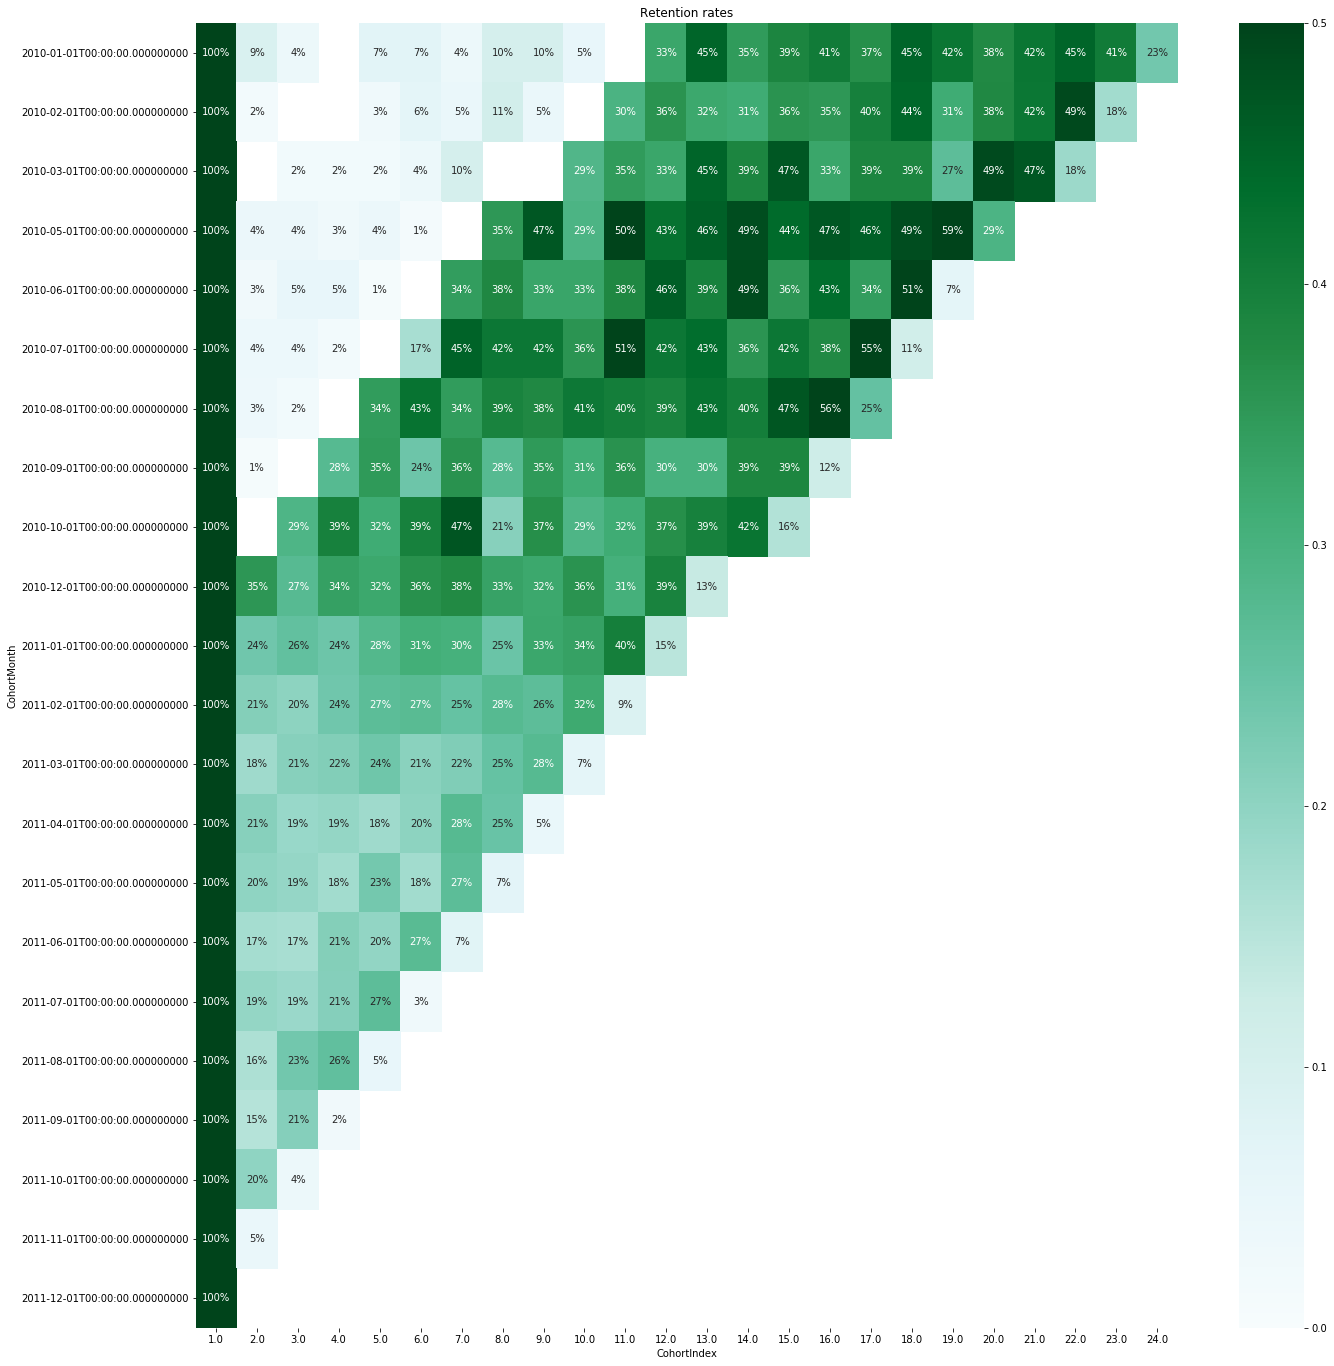

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 24))
plt.title('Retention rates')

sns.heatmap(data = retention, annot = True, fmt = '.0%', vmin = 0.0, vmax = 0.5, cmap = 'BuGn')
plt.show()